# Streaming Martingale Monitoring

This notebook provides an interactive streaming martingale monitoring workflow.
It tracks a streaming anomaly score, conformal p-values, and three martingale evidence trajectories.


## Import

Load dependencies for synthetic streaming data, conformal p-values, and visualization.


In [1]:
from __future__ import annotations

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest

from nonconform import ConformalDetector, Split
from nonconform.martingales import (
    AlarmConfig,
    PowerMartingale,
    SimpleJumperMartingale,
    SimpleMixtureMartingale,
)

## Setup

Create training data from a stable regime, then stream data with a distribution shift in the second half.


In [2]:
rng = np.random.default_rng(42)

# Train/calibration data
x_train = rng.standard_normal((400, 5))

# Stream with a shift in the second half
x_stream_normal = rng.standard_normal((80, 5))
x_stream_shifted = rng.standard_normal((80, 5)) + 2.0
x_stream = np.vstack([x_stream_normal, x_stream_shifted])

shift_start = len(x_stream_normal) + 1
n_steps = len(x_stream)

detector = ConformalDetector(
    detector=IsolationForest(random_state=42),
    strategy=Split(n_calib=0.2),
    score_polarity="auto",
    seed=42,
)
detector.fit(x_train)

alarms = AlarmConfig(ville_threshold=100.0)
martingales = {
    "power": PowerMartingale(epsilon=0.5, alarm_config=alarms),
    "mixture": SimpleMixtureMartingale(
        epsilons=[0.25, 0.5, 0.75, 1.0], alarm_config=alarms
    ),
    "jumper": SimpleJumperMartingale(jump=0.01, alarm_config=alarms),
}

print(
    f"x_train={x_train.shape}, x_stream={x_stream.shape}, "
    f"shift_start_step={shift_start}"
)

x_train=(400, 5), x_stream=(160, 5), shift_start_step=81


## Stream Processing

For each incoming point we compute a raw anomaly score, conformal p-value, and update each martingale.


In [3]:
records: list[dict[str, float | int]] = []
first_alarm_step: dict[str, int | None] = {name: None for name in martingales}

for step, x_t in enumerate(x_stream, start=1):
    x_t_row = x_t.reshape(1, -1)
    score_t = float(detector.score_samples(x_t_row)[0])
    p_t = float(detector.compute_p_values(x_t_row)[0])

    row: dict[str, float | int] = {
        "step": step,
        "anomaly_score": score_t,
        "p_value": p_t,
    }

    for name, martingale in martingales.items():
        state = martingale.update(p_t)
        row[f"{name}_M"] = state.martingale

        if "ville" in state.triggered_alarms and first_alarm_step[name] is None:
            first_alarm_step[name] = step

    records.append(row)

df = pd.DataFrame.from_records(records)
df.head()

,step,anomaly_score,p_value,power_M,mixture_M,jumper_M
0,1,-0.224104,0.827160,0.549762,0.656109,1.000000
1,2,-0.188114,0.419753,0.424276,0.573810,0.982673
2,3,-0.127246,0.086420,0.721625,0.738000,0.916167
3,4,-0.237717,0.888889,0.382700,0.556209,0.874674
4,5,-0.231601,0.864198,0.205836,0.457845,0.917974


## Final States

Summarize the final evidence values and first Ville alarm time for each martingale.


In [4]:
summary_rows = []
for name, martingale in martingales.items():
    state = martingale.state
    summary_rows.append(
        {
            "martingale": name,
            "step": state.step,
            "M": state.martingale,
            "CUSUM": state.cusum,
            "SR": state.shiryaev_roberts,
            "first_ville_alarm_step": first_alarm_step[name],
        }
    )

summary = pd.DataFrame(summary_rows)
summary

,martingale,step,M,CUSUM,SR,first_ville_alarm_step
0,power,160,7.812217e+44,8.829194e+50,6.597802e+51,92
1,mixture,160,1.998209e+44,7.805535e+44,5.239512e+46,89
2,jumper,160,2.506623e+13,5.952630e+13,3.205985e+15,92


## Streaming Process View

Visualize how the stream evolves from reference behavior to shifted behavior.


In [ ]:
pca = PCA(n_components=2, random_state=42)
stream_2d = pca.fit_transform(x_stream)

normal_mask = df["step"] < shift_start
shifted_mask = ~normal_mask
feature_norm = np.linalg.norm(x_stream, axis=1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: 2D projection of stream points by regime
axes[0].scatter(
    stream_2d[normal_mask, 0],
    stream_2d[normal_mask, 1],
    s=36,
    alpha=0.75,
    color="#1f77b4",
    label="Reference segment",
)
axes[0].scatter(
    stream_2d[shifted_mask, 0],
    stream_2d[shifted_mask, 1],
    s=36,
    alpha=0.75,
    color="#d62728",
    label="Shifted segment",
)
axes[0].set_title("Stream distribution in PCA space")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")
axes[0].legend(loc="best")

# Right: magnitude of each sample over time
axes[1].plot(df["step"], feature_norm, color="#4d4d4d", lw=1.6, label="||x_t||_2")
axes[1].plot(
    df["step"],
    pd.Series(feature_norm).rolling(window=10, min_periods=1).mean(),
    color="#ff7f0e",
    lw=2.0,
    label="rolling mean (window=10)",
)
axes[1].axvline(shift_start, color="#8c564b", ls=":", lw=1.2)
axes[1].axvspan(shift_start - 0.5, n_steps + 0.5, color="#ff9896", alpha=0.12)
axes[1].set_title("Stream signal magnitude by step")
axes[1].set_xlabel("stream step")
axes[1].set_ylabel("L2 norm")
axes[1].legend(loc="upper left")

fig.suptitle("Streaming process diagnostics", fontsize=13)
fig.tight_layout()
plt.show()

## Evidence Visualization

These panels combine anomaly score, p-values, and martingale trajectories for step-by-step interpretation.


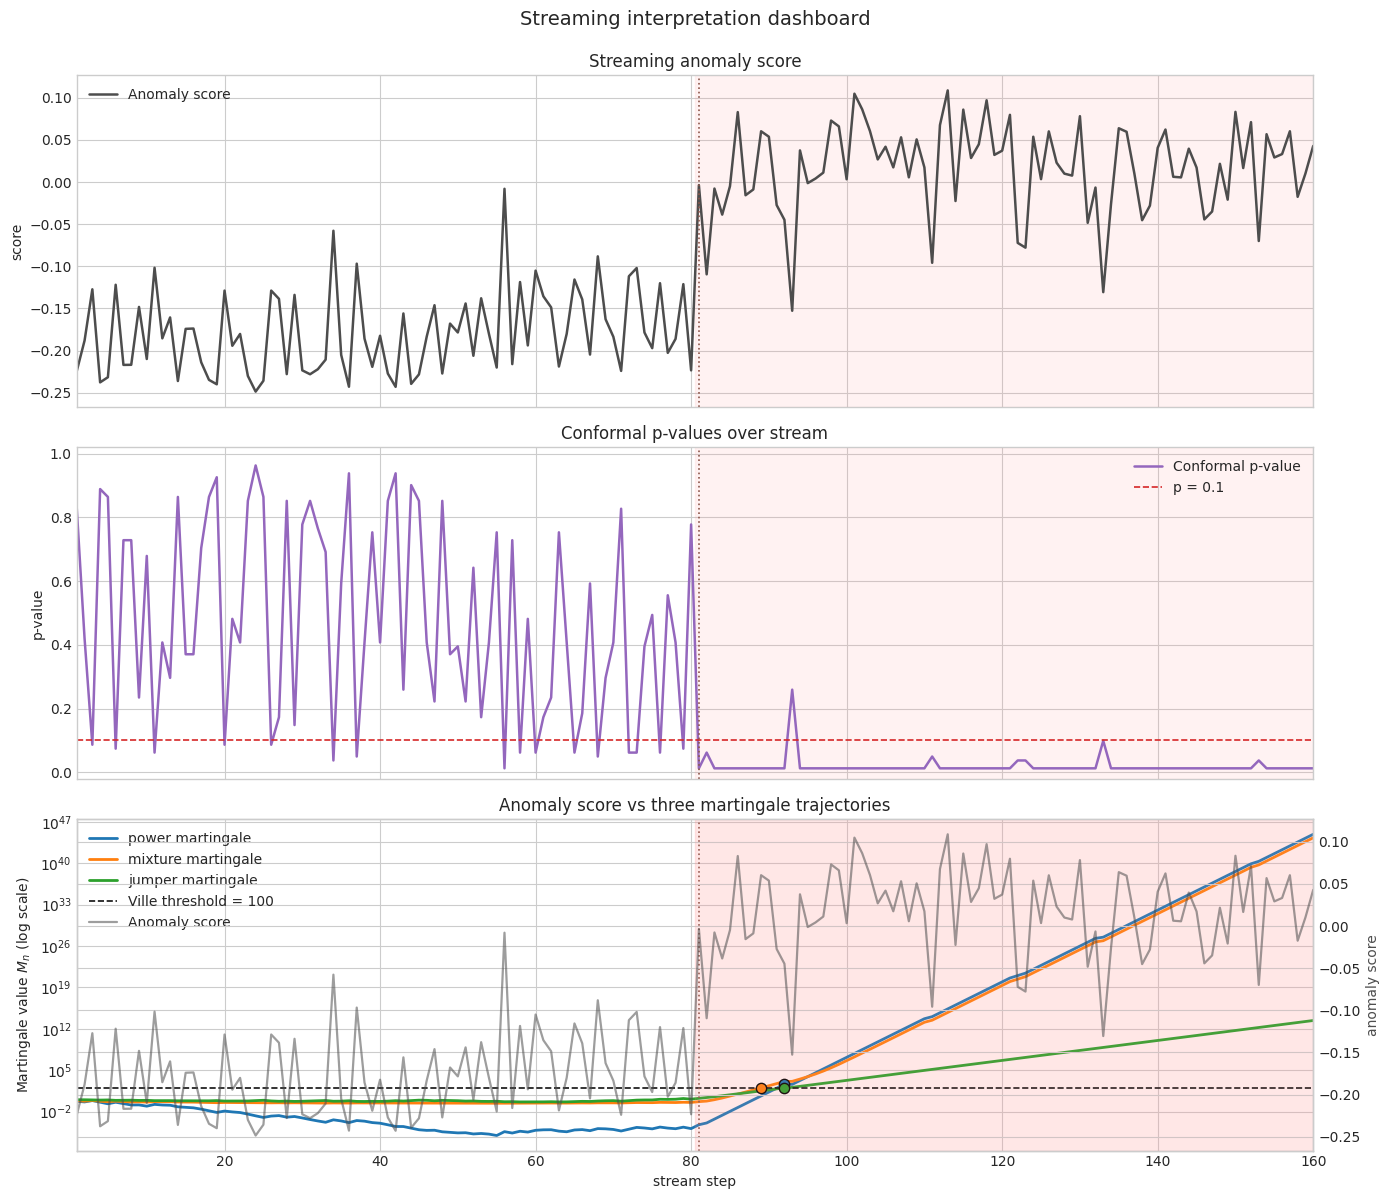

In [5]:
plt.style.use("seaborn-v0_8-whitegrid")

colors = {
    "power": "#1f77b4",
    "mixture": "#ff7f0e",
    "jumper": "#2ca02c",
}

fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# 1) Raw anomaly score
axes[0].plot(
    df["step"],
    df["anomaly_score"],
    color="#4d4d4d",
    lw=1.8,
    label="Anomaly score",
)
axes[0].set_title("Streaming anomaly score")
axes[0].set_ylabel("score")
axes[0].legend(loc="upper left")

# 2) Conformal p-values
axes[1].plot(
    df["step"],
    df["p_value"],
    color="#9467bd",
    lw=1.8,
    label="Conformal p-value",
)
axes[1].axhline(0.1, color="#d62728", ls="--", lw=1.2, label="p = 0.1")
axes[1].set_title("Conformal p-values over stream")
axes[1].set_ylabel("p-value")
axes[1].set_ylim(-0.02, 1.02)
axes[1].legend(loc="upper right")

# 3) Combined evidence view: martingales and anomaly score
for name in ["power", "mixture", "jumper"]:
    axes[2].plot(
        df["step"],
        df[f"{name}_M"],
        color=colors[name],
        lw=2.0,
        label=f"{name} martingale",
    )

axes[2].axhline(
    alarms.ville_threshold,
    color="#111111",
    ls="--",
    lw=1.2,
    label=f"Ville threshold = {alarms.ville_threshold:g}",
)

for name, alarm_step in first_alarm_step.items():
    if alarm_step is not None:
        m_val = float(df.loc[df["step"] == alarm_step, f"{name}_M"].iloc[0])
        axes[2].scatter(
            alarm_step,
            m_val,
            color=colors[name],
            s=55,
            marker="o",
            edgecolor="black",
            zorder=3,
        )

axes[2].set_yscale("log")
axes[2].set_title("Anomaly score vs three martingale trajectories")
axes[2].set_ylabel("Martingale value $M_n$ (log scale)")
axes[2].set_xlabel("stream step")

ax2 = axes[2].twinx()
ax2.plot(
    df["step"],
    df["anomaly_score"],
    color="#4d4d4d",
    alpha=0.55,
    lw=1.6,
    label="Anomaly score",
)
ax2.set_ylabel("anomaly score", color="#4d4d4d")

# Add regime context across all panels
for ax in [*axes, ax2]:
    ax.axvspan(shift_start - 0.5, n_steps + 0.5, color="#ff9896", alpha=0.12)

for ax in axes:
    ax.axvline(shift_start, color="#8c564b", ls=":", lw=1.2)

axes[2].set_xlim(1, n_steps)

h1, l1 = axes[2].get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
axes[2].legend(h1 + h2, l1 + l2, loc="upper left")

fig.suptitle("Streaming interpretation dashboard", fontsize=14, y=0.995)
fig.tight_layout()
plt.show()